In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
import scipy as sp
import random
%matplotlib inline

In [2]:
def easy_func(x):
    a, b, c = -2, 3, 4
    return a * x**2 + b * x + c

def hard_func(x):
    a, b, c = 50, 0.5, 1
    return x * np.tanh(a * (x - b)) + c

def trapezoid_rule(f, start, end, n=100):
    integral_sum = 0
    dx = (end - start) / n
    for i in range(n):
        integral_sum += (f(start + dx * i) + f(start + dx * (i+1))) / 2 * dx
    return integral_sum

def trap_adapt(f, start, end, tolerance=1e-5):
    big_trap = (f(start) + f(end)) / 2 * (end - start)
    mid = (start + end) / 2
    two_little_traps = (f(start) + f(mid)) / 2 * (mid - start) + \
        (f(mid) + f(end)) / 2 * (end - mid)
    # base case
    if abs((big_trap - two_little_traps)/two_little_traps) <= tolerance:
        return two_little_traps
    else:
        return trap_adapt(f, start, mid, tolerance) + trap_adapt(f, mid, end, tolerance)

# Adaptive Integration

How do computers do integration? This lecture goes over a (simple) version that 

## Introduction

Suppose we wish to integrate a function. That is, we wish to find the area under a certain section of a curve.
That might look something like this:

$$\int_a^b f(x)\mathrm{d}x$$

or more specifically, where $f(x) = -2x^2+ 3x + 4$ and $a, b = 0, 1$:

$$\int_0^1 -2x^2+ 3x + 4\ \mathrm{d}x$$

[]

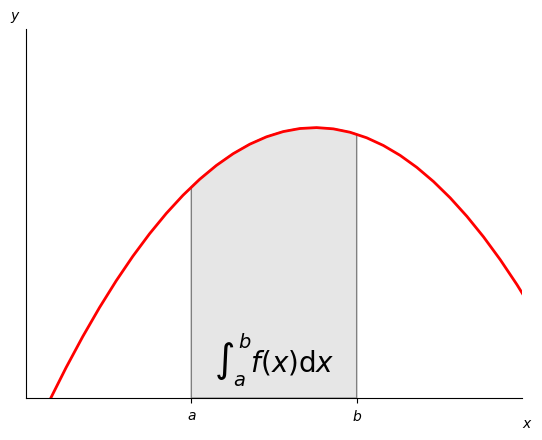

In [3]:
# example code
a, b = 0, 1  # integral limits
x = np.linspace(-5, 5, 100)
y = easy_func(x)
fig, ax = plt.subplots()
ax.plot(x, y, 'r', linewidth=2)
ax.set_ylim(bottom=0)
plt.ylim([0,7])
plt.xlim([-1,2])

# Make the shaded region
ix = np.linspace(a, b, 100)
iy = easy_func(ix)
verts = [(a, 0), *zip(ix, iy), (b, 0)]
poly = Polygon(verts, facecolor='0.9', edgecolor='0.5')
ax.add_patch(poly)

ax.text(0.5 * (a + b), 0.5, r"$\int_a^b f(x)\mathrm{d}x$",
        horizontalalignment='center', fontsize=20)

fig.text(0.9, 0.05, '$x$')
fig.text(0.1, 0.9, '$y$')

ax.spines[['top', 'right']].set_visible(False)
ax.set_xticks([a, b], labels=['$a$', '$b$'])
ax.set_yticks([])

Now, this is straight forward to do if we understand the basic rules of polynomial integreation. The solution to this integral is: 

$$\frac{dF(x)}{dx} = f(x)$$

$$F(x) = \frac{-2}{3}x^3+ \frac{3}{2}x^2 + 4x$$

$$\int_a^b f(x)\mathrm{d}x = F(b) - F(a)$$

$$\int_0^1 -2x^2+ 3x + 4\ \mathrm{d}x = \frac{-2}{3}(1)^3+ \frac{3}{2}(1)^2 + 4(1) - \left(\frac{-2}{3}(0)^3+ \frac{3}{2}(0)^2 + 4(0)\right) = \frac{-2}{3} + \frac{3}{2} + 4 - 0 \approx 4.8\overline{333} $$

But what if we want a computer to do this for us? What if we want to integrate any arbitrary function?

## The Trapezoid Rule

Well, you may already be familiar with the trapazoid rule. Simply split the area to be integrated into trapazoids and add up the area of the trapazoids. Recall that the area of a trapazoid is:

<img src="https://external-content.duckduckgo.com/iu/?u=https%3A%2F%2Fcurvebreakerstestprep.com%2Fwp-content%2Fuploads%2F2021%2F06%2FArea-of-a-Trapezoid.png&f=1&nofb=1&ipt=544b58b82763375df2f382a28c0c51d95a53054e95b05c3b7dca9658768f9871&ipo=images" alt="drawing" width="600"/>

And if we take the two base lengths $a$ and $b$ of the trapazoid to be $f(a)$ and $f(b)$ and $h$ to be $(b - a)$ or the distance between the two points we get something that looks like this:

[]

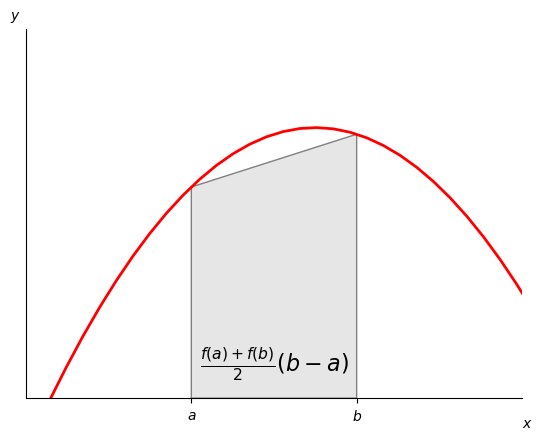

In [4]:
# example code
a, b = 0, 1  # integral limits
x = np.linspace(-5, 5, 100)
y = easy_func(x)
fig, ax = plt.subplots()
ax.plot(x, y, 'r', linewidth=2)
ax.set_ylim(bottom=0)
plt.ylim([0,7])
plt.xlim([-1,2])

# Make the shaded region
ix = np.linspace(a, b, 2)
iy = easy_func(ix)
verts = [(a, 0), *zip(ix, iy), (b, 0)]
poly = Polygon(verts, facecolor='0.9', edgecolor='0.5')
ax.add_patch(poly)

ax.text(0.5 * (a + b), 0.5, r"$\frac{f(a) + f(b)}{2} (b - a)$",
        horizontalalignment='center', fontsize=16)

fig.text(0.9, 0.05, '$x$')
fig.text(0.1, 0.9, '$y$')

ax.spines[['top', 'right']].set_visible(False)
ax.set_xticks([a, b], labels=['$a$', '$b$'])
ax.set_yticks([])

This gives a value of $4.75$ which is a pretty good first approximation of the actual integral ($\approx 17\%$ relative error). If we want to, we can just break the trapazoids into pieces and get a more accurate answer. That is:

$$dx = \frac{b-a}{n}$$

$$\sum^{n-1}_{i=0} \frac{f(a + i \cdot dx) + f(a + (i+1)\cdot dx)}{2} dx$$

This makes our trapazoid look like this:

[]

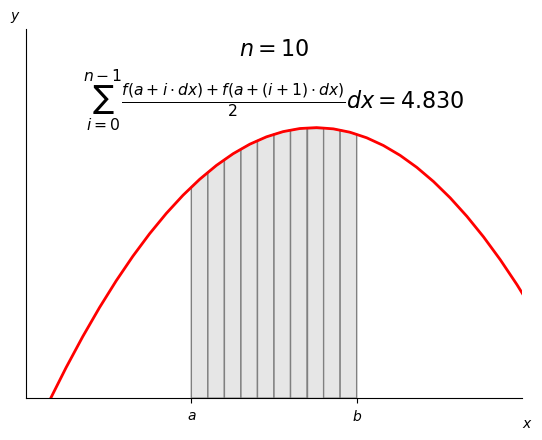

In [5]:
# example code
a, b = 0, 1  # integral limits
x = np.linspace(-5, 5, 100)
y = easy_func(x)
fig, ax = plt.subplots()
ax.plot(x, y, 'r', linewidth=2)
ax.set_ylim(bottom=0)
plt.ylim([0,7])
plt.xlim([-1,2])
n=10
dx = (b-a)/n 
# Make the shaded region
for i in range(n):
    
    ix = np.linspace(a + i*dx, a+(i+1)*dx, 2)
    iy = easy_func(ix)
    verts = [(a + i*dx, 0), *zip(ix, iy), (a+(i+1)*dx, 0)]
    poly = Polygon(verts, facecolor='0.9', edgecolor='0.5')
    ax.add_patch(poly)

ax.text(0.5 * (a + b), 5.5, r"$\sum^{n-1}_{i=0} \frac{f(a + i \cdot dx) + f(a + (i+1)\cdot dx)}{2} dx = 4.830$",
        horizontalalignment='center', fontsize=16)
ax.text(0.5 * (a + b), 6.5, r"$n=10$",
        horizontalalignment='center', fontsize=16)

fig.text(0.9, 0.05, '$x$')
fig.text(0.1, 0.9, '$y$')

ax.spines[['top', 'right']].set_visible(False)
ax.set_xticks([a, b], labels=['$a$', '$b$'])
ax.set_yticks([])

Using $n=10$ number of trapazoids gives $4.830$, a much better approximation. We can increase $n$ until we get to a desired accuracy.

In [6]:
for i in range(5):
    n=10**(i+1)
    print(f"trapezoid rule (n={n:7d}): {trapezoid_rule(easy_func, 0, 1, n=n):.10f}")


trapezoid rule (n=     10): 4.8300000000
trapezoid rule (n=    100): 4.8333000000
trapezoid rule (n=   1000): 4.8333330000
trapezoid rule (n=  10000): 4.8333333300
trapezoid rule (n= 100000): 4.8333333333


We see that at $n=100{,}000$ we get 10 decimals of accuracy. This is good, but can be taxing on a computer. Especially when you need to do many accurate integrations for some complex calculation. There is another problem too. What if we have an integral that looks like this?

$$\int^{1}_{0} x \,tanh\left(a \left(x-b\right)\right) + c \, dx$$

This one is not easy to do by hand. It also looks like this on a graph:

[]

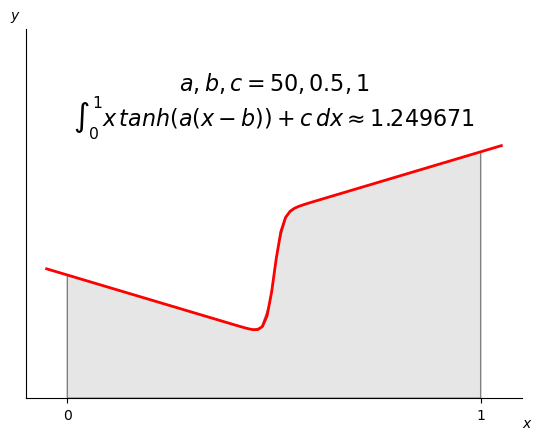

In [7]:
func = hard_func
fig, ax = plt.subplots()
a, b = 0, 1
x = np.linspace(-.05,1.05,100)
plt.plot(x,func(x), '-r', linewidth=2)
plt.ylim([0,3])
plt.xlim([-.1,1.1])
# Make the shaded region
ix = np.linspace(a, b)
iy = func(ix)
verts = [(a, 0), *zip(ix, iy), (b, 0)]
poly = Polygon(verts, facecolor='0.9', edgecolor='0.5')
ax.add_patch(poly)
fig.text(0.9, 0.05, '$x$')
fig.text(0.1, 0.9, '$y$')

ax.text(0.5 * (a + b), 2.2, r"$\int^{1}_{0} x \,tanh\left(a \left(x-b\right)\right) + c \, dx \approx 1.249671$",
        horizontalalignment='center', fontsize=16)
ax.text(0.5 * (a + b), 2.5, r"$a, b, c = 50, 0.5, 1$",
        horizontalalignment='center', fontsize=16)

ax.spines[['top', 'right']].set_visible(False)
ax.set_xticks([a, b], labels=['0', '1'])
ax.set_yticks([])

Also to integrate using the trapazoid rule can be a problem. Splitting the integral into 10,000 trapezoids gets an accurate answer but is slow. It is a complex fuction that is computationally expensive to calcualte.

[]

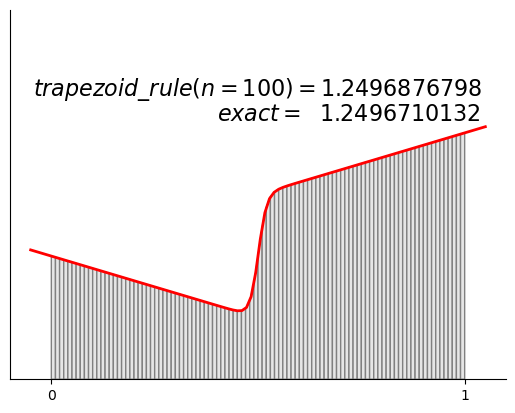

In [8]:
func = hard_func
n=100#n = 10000 took several seconds to compute
fig, ax = plt.subplots()
a, b = 0, 1
x = np.linspace(-.05,1.05,100)
plt.plot(x,func(x), '-r', linewidth=2)
plt.ylim([0,3])
plt.xlim([-.1,1.1])

dx = (b-a)/n 
# Make the shaded region
for i in range(n):
    ix = np.linspace(a + i*dx, a+(i+1)*dx, 2)
    iy = func(ix)
    verts = [(a + i*dx, 0), *zip(ix, iy), (a+(i+1)*dx, 0)]
    poly = Polygon(verts, facecolor='0.9', edgecolor='0.5')
    ax.add_patch(poly)

ax.text(0.5 * (a + b), 2.3, r"$trapezoid\_"+f"rule(n={n})={trapezoid_rule(hard_func, 0, 1, n=n):.10f}$",
        horizontalalignment='center', fontsize=16)
ax.text(0.4* (a + b), 2.1, f"$exact=$  1.2496710132",
        horizontalalignment='left', fontsize=16)


ax.spines[['top', 'right']].set_visible(False)
ax.set_xticks([a, b], labels=['0', '1'])
ax.set_yticks([])

But, consider this: What if we could choose how big we wanted each trapezoid could be? If it were up to me I would do it like this:

[]

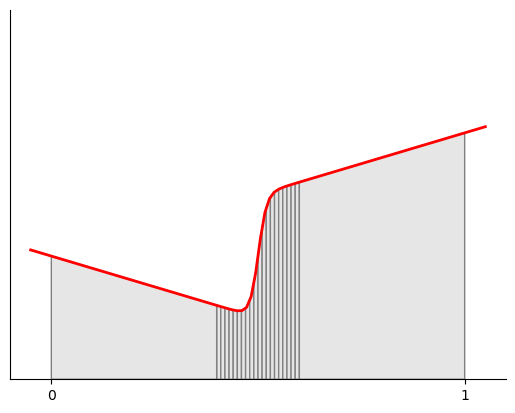

In [24]:
func = hard_func
n=20#n = 10000 took several seconds to compute
fig, ax = plt.subplots()
aa, bb = 0.4, .6
a, b = aa, bb
x = np.linspace(-.05,1.05,100)
plt.plot(x,func(x), '-r', linewidth=2)
plt.ylim([0,3])
plt.xlim([-.1,1.1])

dx = (b-a)/n 
# Make the shaded region
for i in range(n):
    ix = np.linspace(a + i*dx, a+(i+1)*dx, 2)
    iy = func(ix)
    verts = [(a + i*dx, 0), *zip(ix, iy), (a+(i+1)*dx, 0)]
    poly = Polygon(verts, facecolor='0.9', edgecolor='0.5')
    ax.add_patch(poly)

dx = 1 - bb
a, b = b, 1
i=0
ix = np.linspace(a + i*dx, a+(i+1)*dx, 2)
iy = func(ix)
verts = [(a + i*dx, 0), *zip(ix, iy), (a+(i+1)*dx, 0)]
poly = Polygon(verts, facecolor='0.9', edgecolor='0.5')
ax.add_patch(poly)

dx = aa - 0
a, b = 0, aa
i=0
ix = np.linspace(a + i*dx, a+(i+1)*dx, 2)
iy = func(ix)
verts = [(a + i*dx, 0), *zip(ix, iy), (a+(i+1)*dx, 0)]
poly = Polygon(verts, facecolor='0.9', edgecolor='0.5')
ax.add_patch(poly)

# ax.text(0.5 * (a + b), 2.3, r"$trapezoid\_"+f"rule(n={n})={trapezoid_rule(hard_func, 0, 1, n=n):.10f}$",
#         horizontalalignment='center', fontsize=16)
# ax.text(0.4* (a + b), 2.1, f"$exact=$  1.2496710132",
#         horizontalalignment='left', fontsize=16)

a,b = 0,1
ax.spines[['top', 'right']].set_visible(False)
ax.set_xticks([a, b], labels=['0', '1'])
ax.set_yticks([])

You see, this way we could do this in many fewer iterations and get a very accurate answer! But how do we program a computer to figure this out?

## Recursion!

<img src="https://external-content.duckduckgo.com/iu/?u=https%3A%2F%2Fcdn.slidesharecdn.com%2Fss_thumbnails%2Frecursion-130206094649-phpapp01-thumbnail-4.jpg%3Fcb%3D1360144228&f=1&nofb=1&ipt=5cf99a9dc9713a5a1d3339b9393324e779c2181af47d9659d932553e186f1372&ipo=images" alt="recursion" width="600"/>

We can write a recursive function that will automatically and correctly choose the correct spacing for difficult functions like the one above! Lets try it!

In [10]:
print(f"trap:       {trapezoid_rule(easy_func, 0, 1, n=10):.10f}")
print(f"trap_adapt: {trap_adapt(easy_func, 0, 1):.10f}")
print(f"Scipy:      {sp.integrate.quad(easy_func, 0, 1)[0]:.10f}")

trap:       4.8300000000
trap_adapt: 4.8333282471
Scipy:      4.8333333333


In [25]:
### CONTINUE HERE!

In [11]:
print(f"trap:       {trapezoid_rule(hard_func, 0, 1, n=10000):.10f}")
print(f"trap_adapt: {trap_adapt(hard_func, 0, 1):.10f}")
print(f"Scipy:      {sp.integrate.quad(hard_func, 0, 1)[0]:.10f}")

trap:       1.2496710149
trap_adapt: 1.2496706792
Scipy:      1.2496710132


$$f(x) = \int^{1}_{0} x \,tanh\left(a \left(x-b\right)\right) + c \, dx$$

[]

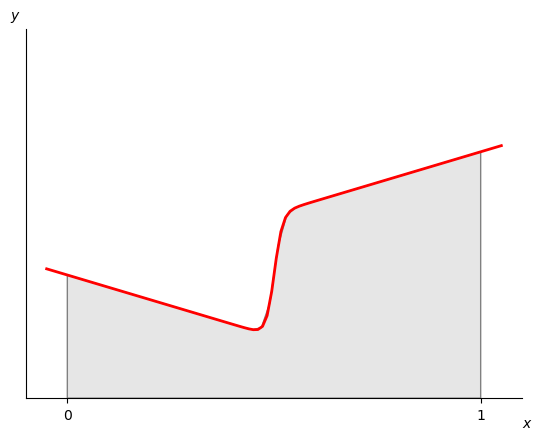

In [12]:
func = hard_func
fig, ax = plt.subplots()
a, b = 0, 1
x = np.linspace(-.05,1.05,100)
plt.plot(x,func(x), '-r', linewidth=2)
plt.ylim([0,3])
plt.xlim([-.1,1.1])
# Make the shaded region
ix = np.linspace(a, b)
iy = func(ix)
verts = [(a, 0), *zip(ix, iy), (b, 0)]
poly = Polygon(verts, facecolor='0.9', edgecolor='0.5')
ax.add_patch(poly)
fig.text(0.9, 0.05, '$x$')
fig.text(0.1, 0.9, '$y$')

ax.spines[['top', 'right']].set_visible(False)
ax.set_xticks([a, b], labels=['0', '1'])
ax.set_yticks([])

$$f(x) = \int^{1}_{0} ax^2 + bx + c \, dx$$

[]

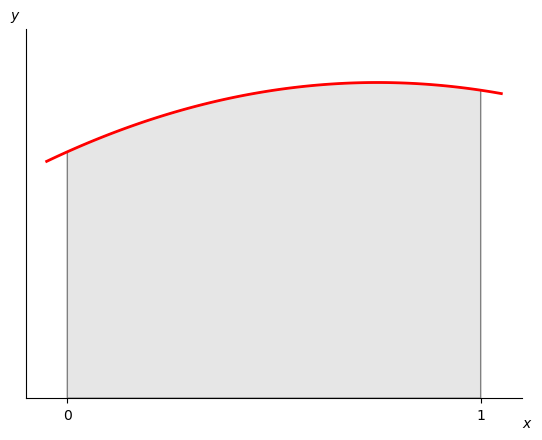

In [13]:
func = easy_func
fig, ax = plt.subplots()
a, b = 0, 1
x = np.linspace(-.05,1.05,100)
plt.plot(x,func(x), '-r', linewidth=2)
plt.ylim([0,6])
plt.xlim([-.1,1.1])
# Make the shaded region
ix = np.linspace(a, b)
iy = func(ix)
verts = [(a, 0), *zip(ix, iy), (b, 0)]
poly = Polygon(verts, facecolor='0.9', edgecolor='0.5')
ax.add_patch(poly)
fig.text(0.9, 0.05, '$x$')
fig.text(0.1, 0.9, '$y$')

ax.spines[['top', 'right']].set_visible(False)
ax.set_xticks([a, b], labels=['0', '1'])
ax.set_yticks([])

In [14]:
# example code
# a, b = 0, 1  # integral limits
# x = np.linspace(0, 10)
# y = easy_func(x)
# fig, ax = plt.subplots()
# ax.plot(x, y, 'r', linewidth=2)
# ax.set_ylim(bottom=0)

# # Make the shaded region
# ix = np.linspace(a, b)
# iy = easy_func(ix)
# verts = [(a, 0), *zip(ix, iy), (b, 0)]
# poly = Polygon(verts, facecolor='0.9', edgecolor='0.5')
# ax.add_patch(poly)

# ax.text(0.5 * (a + b), 0.5, r"$\int_a^b f(x)\mathrm{d}x$",
#         horizontalalignment='center', fontsize=20)

# fig.text(0.9, 0.05, '$x$')
# fig.text(0.1, 0.9, '$y$')

# ax.spines[['top', 'right']].set_visible(False)
# ax.set_xticks([a, b], labels=['$a$', '$b$'])
# ax.set_yticks([])

## Push this further

Try the following to deepen your knowledge:

- We have only used one example function for this algorithm. Try using the adaptive trapazoid method to integrate various functions. Are there any potential problems with this method? Try to find an example where it may give you a wrong calculated integral.
- Try rewriting the adaptive algorithm using [Simpson's Rule](https://en.wikipedia.org/wiki/Simpson's_rule). In what ways is it better? faster? Compare it to the trapazoid version and explain any advantages or drawbacks to using your rewritten function.
- Usually, recursive programming is not ideal for stablity of programs. Could you write the adaptive trapazoid method without recursion? What are the advantages and drawbacks to this?
- Research how these algorithms are used in production code. Look up [adaptive quadrature](https://en.wikipedia.org/wiki/Adaptive_quadrature) or research the Python function [scipy.integrate.quad](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.quad.html). How are these methods different to the ones we programmed here? Are there any drawbacks to their methods?